<a href="https://colab.research.google.com/github/Thirukumaran02/AI-Powered-Customer-Journey-Sentiment-Analysis/blob/main/amazon_casestudy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install snowflake-connector-python pandas --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.5/74.5 kB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 20.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.0/105.0 kB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.3/139.3 kB 9.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.0/14.0 MB 72.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 479.4/479.4 kB 28.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 5.8 MB/s eta 0:00:00


In [2]:
import pandas as pd
import snowflake.connector
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from scipy.sparse import hstack
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
# Replace with your Snowflake details
ctx = snowflake.connector.connect(
    user="Thiru",
    password="Thirukumaran1108",
    account="vxpqfdk-yl32948",
    warehouse="COMPUTE_WH",
    database="AMAZON_INSIGHTS",
    schema="RAW_DATA")


# Test connection
cs = ctx.cursor()
cs.execute("SELECT CURRENT_DATE;")
print("Connected to Snowflake, current date:", cs.fetchone()[0])
cs.close()

Connected to Snowflake, current date: 2025-09-19


True

In [4]:
# Step 1: Load & Clean Data from Snowflake

# Load raw reviews table
query = "SELECT * FROM raw_data.amazon_reviews;"
df_raw = pd.read_sql(query, ctx)
print("Rows loaded from Snowflake:", len(df_raw))
df_raw.head(3)

# 1.1: Remove duplicates & nulls
df_clean = df_raw.drop_duplicates(subset=["REVIEW_ID"])
df_clean = df_clean.dropna(subset=["REVIEW_TEXT", "REVIEW_RATING", "PRODUCT_ID"])

# 1.2: Standardize data
df_clean["REVIEW_TEXT"] = df_clean["REVIEW_TEXT"].str.strip()
df_clean["COUNTRY"] = df_clean["COUNTRY"].str.upper()
df_clean["CITY"] = df_clean["CITY"].str.title()
df_clean["PRODUCT_CATEGORY"] = df_clean["PRODUCT_CATEGORY"].str.title()
df_clean["REVIEW_DATE"] = pd.to_datetime(df_clean["REVIEW_DATE"], errors="coerce")
df_clean = df_clean.dropna(subset=["REVIEW_DATE"])

# 1.3: Detect missing languages
!pip install langdetect --quiet
from langdetect import detect

def detect_lang_safe(text):
    try:
        return detect(text)
    except:
        return "unknown"

mask = df_clean["REVIEW_LANGUAGE"].isna() | (df_clean["REVIEW_LANGUAGE"]=="") | (df_clean["REVIEW_LANGUAGE"]=="unknown")
df_clean.loc[mask, "REVIEW_LANGUAGE"] = df_clean.loc[mask, "REVIEW_TEXT"].apply(detect_lang_safe)

# 1.4: Remove outliers & anomalies
df_clean = df_clean[(df_clean["REVIEW_RATING"] >= 1) & (df_clean["REVIEW_RATING"] <= 5)]
df_clean = df_clean[df_clean["DELIVERY_TIME_DAYS"] >= 0]
df_clean = df_clean[df_clean["SUPPORT_RESOLUTION_TIME"] >= 0]

# 1.5: Add derived features
df_clean["year"] = df_clean["REVIEW_DATE"].dt.year
df_clean["month"] = df_clean["REVIEW_DATE"].dt.month
df_clean["review_len"] = df_clean["REVIEW_TEXT"].str.len()
df_clean["word_count"] = df_clean["REVIEW_TEXT"].str.split().apply(len)
df_clean["sentiment_from_rating"] = df_clean["REVIEW_RATING"].apply(lambda r: "Positive" if r>=4 else ("Neutral" if r==3 else "Negative"))
df_clean["churn_risk_cat"] = df_clean["CHURN_RISK"].astype("category")

# 2.6: Check missing KPIs
missing_kpis = df_clean[["NPS_RESPONSE", "LOYALTY_STATUS", "SUPPORT_TICKET_FLAG"]].isna().sum()
print("Missing KPI counts:\n", missing_kpis)

# 2.7: Review final cleaned data
print("Cleaned Data Shape:", df_clean.shape)
print("Missing Values:\n", df_clean.isna().sum())
print("Data Types:\n", df_clean.dtypes)


/tmp/ipython-input-2002294363.py:5: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_raw = pd.read_sql(query, ctx)


Rows loaded from Snowflake: 500000
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 8.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
Missing KPI counts:
 NPS_RESPONSE           0
LOYALTY_STATUS         0
SUPPORT_TICKET_FLAG    0
dtype: int64
Cleaned Data Shape: (500000, 26)
Missing Values:
 REVIEW_ID                  0
CUSTOMER_ID                0
PRODUCT_ID                 0
PRODUCT_CATEGORY           0
PRODUCT_PRICE              0
REVIEW_LANGUAGE            0
REVIEW_TEXT                0
REVIEW_RATING              0
REVIEW_DATE                0
JOURNEY_STAGE              0
SENTIMENT_LABEL            0
DELIVERY_TIME_DAYS         0
SUPPORT_TICKET_FLAG        0
SUPPORT_RESOLUTION_TIME    0
COUNTRY                    0
CITY                       0
DEVICE_TYPE                0
NPS_RESPONSE               0
LOYALTY_STATUS             0
CHURN_RISK                 0
year                       0
month                      0
review_len                 0
word_count       

In [5]:
# Step 2: Train/Test Split

from sklearn.model_selection import train_test_split

X = df_clean[["REVIEW_TEXT", "review_len", "word_count",
              "DELIVERY_TIME_DAYS", "SUPPORT_RESOLUTION_TIME", "PRODUCT_PRICE"]]
y = df_clean["sentiment_from_rating"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Training set size:", X_train.shape[0])
print("Testing set size:", X_test.shape[0])


Training set size: 400000
Testing set size: 100000


In [6]:
# Step 3: Save Train/Test Sets to Snowflake
from snowflake.connector.pandas_tools import write_pandas

train_df = X_train.copy()
train_df["sentiment_from_rating"] = y_train
test_df = X_test.copy()
test_df["sentiment_from_rating"] = y_test

train_df = train_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

write_pandas(ctx, train_df, table_name="REVIEWS_TRAIN", schema="PROCESSED_DATA", auto_create_table=True)
write_pandas(ctx, test_df, table_name="REVIEWS_TEST", schema="PROCESSED_DATA", auto_create_table=True)

print("Train/Test sets uploaded to Snowflake.")


Train/Test sets uploaded to Snowflake.


In [7]:
# Step 4: NLP + Numeric Feature Modeling

# TF-IDF vectorization
tfidf = TfidfVectorizer(max_features=10000, ngram_range=(1,2))
X_train_tfidf = tfidf.fit_transform(X_train['REVIEW_TEXT'])
X_test_tfidf = tfidf.transform(X_test['REVIEW_TEXT'])

# Scale numeric features
scaler = StandardScaler(with_mean=False)
X_train_num = scaler.fit_transform(X_train[['review_len','word_count','DELIVERY_TIME_DAYS','SUPPORT_RESOLUTION_TIME','PRODUCT_PRICE']])
X_test_num = scaler.transform(X_test[['review_len','word_count','DELIVERY_TIME_DAYS','SUPPORT_RESOLUTION_TIME','PRODUCT_PRICE']])

# Combine text + numeric
X_train_final = hstack([X_train_tfidf, X_train_num])
X_test_final  = hstack([X_test_tfidf, X_test_num])


=== Logistic Regression (TF-IDF + Numeric) ===
Accuracy: 0.31846

Classification Report:
               precision    recall  f1-score   support

    Negative       0.25      0.45      0.32     24986
     Neutral       0.20      0.29      0.24     19951
    Positive       0.55      0.27      0.36     55063

    accuracy                           0.32    100000
   macro avg       0.34      0.34      0.31    100000
weighted avg       0.41      0.32      0.33    100000



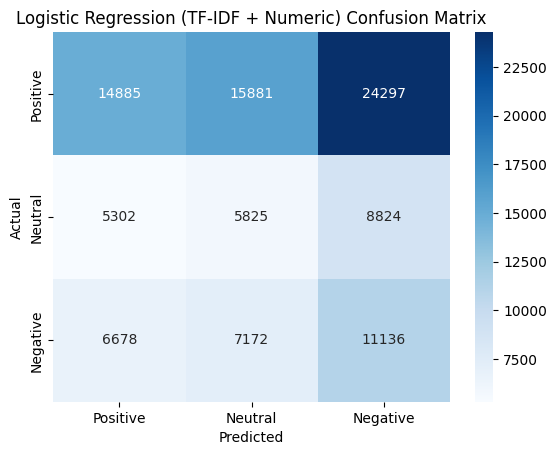

=== XGBoost (TF-IDF + Numeric) ===
Accuracy: 0.55065

Classification Report:
               precision    recall  f1-score   support

    Negative       0.50      0.00      0.00     24986
     Neutral       1.00      0.00      0.00     19951
    Positive       0.55      1.00      0.71     55063

    accuracy                           0.55    100000
   macro avg       0.68      0.33      0.24    100000
weighted avg       0.63      0.55      0.39    100000



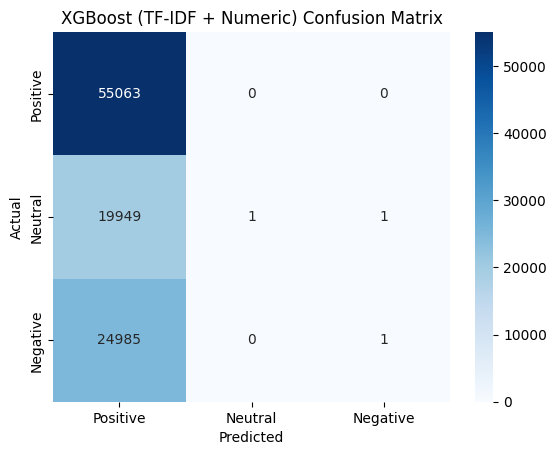

In [9]:
# Step 5: Train Models & Evaluate

from sklearn.preprocessing import LabelEncoder

# Encode target variable
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
y_test_encoded = le.transform(y_test)

# Logistic Regression
lr_model = LogisticRegression(max_iter=2000, class_weight='balanced')
lr_model.fit(X_train_final, y_train_encoded)
y_pred_lr = lr_model.predict(X_test_final)

# XGBoost
xgb_model = XGBClassifier(
    n_estimators=300,
    max_depth=6,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    eval_metric='mlogloss',
    tree_method='hist'
)
xgb_model.fit(X_train_final, y_train_encoded)
y_pred_xgb = xgb_model.predict(X_test_final)

# Decode predictions for evaluation
y_pred_lr_decoded = le.inverse_transform(y_pred_lr)
y_pred_xgb_decoded = le.inverse_transform(y_pred_xgb)

# Evaluation Function
def evaluate_model(y_true, y_pred, model_name):
    print(f"=== {model_name} ===")
    print("Accuracy:", accuracy_score(y_true, y_pred))
    print("\nClassification Report:\n", classification_report(y_true, y_pred, zero_division=0))

    cm = confusion_matrix(y_true, y_pred, labels=["Positive","Neutral","Negative"])
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=["Positive","Neutral","Negative"],
                yticklabels=["Positive","Neutral","Negative"])
    plt.title(f"{model_name} Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

evaluate_model(y_test, y_pred_lr_decoded, "Logistic Regression (TF-IDF + Numeric)")
evaluate_model(y_test, y_pred_xgb_decoded, "XGBoost (TF-IDF + Numeric)")

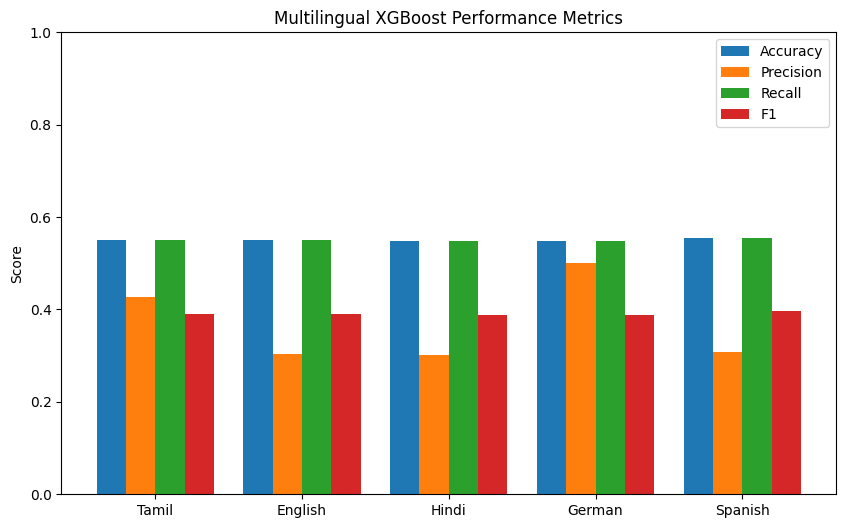

Predictions uploaded to Snowflake successfully.


In [17]:
# ===============================
# Step 6: Multilingual & Product Insights
# ===============================

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# ---- Multilingual Performance ----
languages = df_clean['REVIEW_LANGUAGE'].unique()[:5]  # first 5 languages
summary_list = []

for lang in languages:
    idx = df_clean[df_clean['REVIEW_LANGUAGE'] == lang].index
    y_test_lang = y_test.loc[y_test.index.intersection(idx)]
    y_pred_lang_encoded = y_pred_xgb[y_test.index.isin(idx)]
    y_pred_lang_decoded = le.inverse_transform(y_pred_lang_encoded)

    if len(y_test_lang) > 0:
        summary_list.append([
            lang,
            accuracy_score(y_test_lang, y_pred_lang_decoded),
            precision_score(y_test_lang, y_pred_lang_decoded, average='weighted', zero_division=0),
            recall_score(y_test_lang, y_pred_lang_decoded, average='weighted', zero_division=0),
            f1_score(y_test_lang, y_pred_lang_decoded, average='weighted', zero_division=0)
        ])

df_summary = pd.DataFrame(summary_list, columns=['Language','Accuracy','Precision','Recall','F1'])

# ---- Grouped Bar Chart ----
metrics = ['Accuracy','Precision','Recall','F1']
x = np.arange(len(df_summary['Language']))
width = 0.2

fig, ax = plt.subplots(figsize=(10,6))
colors = ['#1f77b4','#ff7f0e','#2ca02c','#d62728']

for i, metric in enumerate(metrics):
    ax.bar(x + i*width, df_summary[metric], width, label=metric, color=colors[i])

ax.set_xticks(x + width*1.5)
ax.set_xticklabels(df_summary['Language'])
ax.set_ylim(0,1)
ax.set_ylabel('Score')
ax.set_title('XGBoost Multilingual Performance Metrics')
ax.legend()
plt.show()


# ---- Product Category Sentiment Distribution ----
category_summary = df_clean.groupby('PRODUCT_CATEGORY')['sentiment_from_rating'].value_counts(normalize=True).unstack().fillna(0)
category_summary.plot(kind='bar', stacked=True, figsize=(12,6), colormap='Paired')
plt.title("Sentiment Distribution by Product Category")
plt.ylabel("Proportion")
plt.xlabel("Product Category")
plt.xticks(rotation=45, ha='right')
plt.show()


# ---- Churn Risk Distribution ----
churn_summary = df_clean.groupby('churn_risk_cat')['CHURN_RISK'].count().reset_index()
churn_summary.columns = ['Churn Risk','Count']

sns.set(style="whitegrid")
plt.figure(figsize=(8,5))
sns.barplot(x='Churn Risk', y='Count', data=churn_summary, palette='coolwarm')
plt.title("Churn Risk Distribution")
plt.ylabel("Number of Customers")
plt.show()


In [20]:
# 7.Save predictions back to Snowflake
X_test_copy = X_test.copy()
X_test_copy["actual_sentiment"] = y_test
X_test_copy["predicted_sentiment_lr"] = y_pred_lr_decoded
X_test_copy["predicted_sentiment_xgb"] = y_pred_xgb_decoded

X_test_copy = X_test_copy.reset_index(drop=True)

write_pandas(ctx, X_test_copy, table_name="REVIEWS_PREDICTIONS", schema="ANALYSIS_DATA", auto_create_table=True)
print("Predictions uploaded to Snowflake successfully.")

Predictions uploaded to Snowflake successfully.


Net Promoter Score (NPS): -45.47
Customer Satisfaction (CSAT %): 55.06


/tmp/ipython-input-2009431085.py:24: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  churn_summary = df_clean.groupby('churn_risk_cat')['CHURN_RISK'].count().reset_index()
/tmp/ipython-input-2009431085.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Churn Risk', y='Count', data=churn_summary, palette='coolwarm')


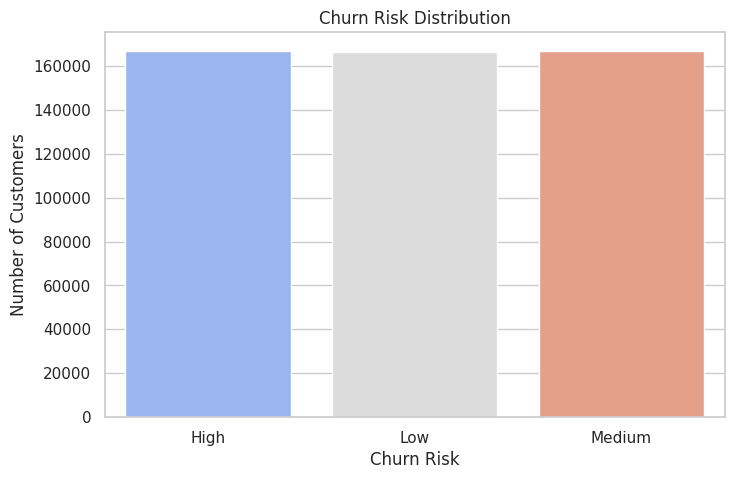

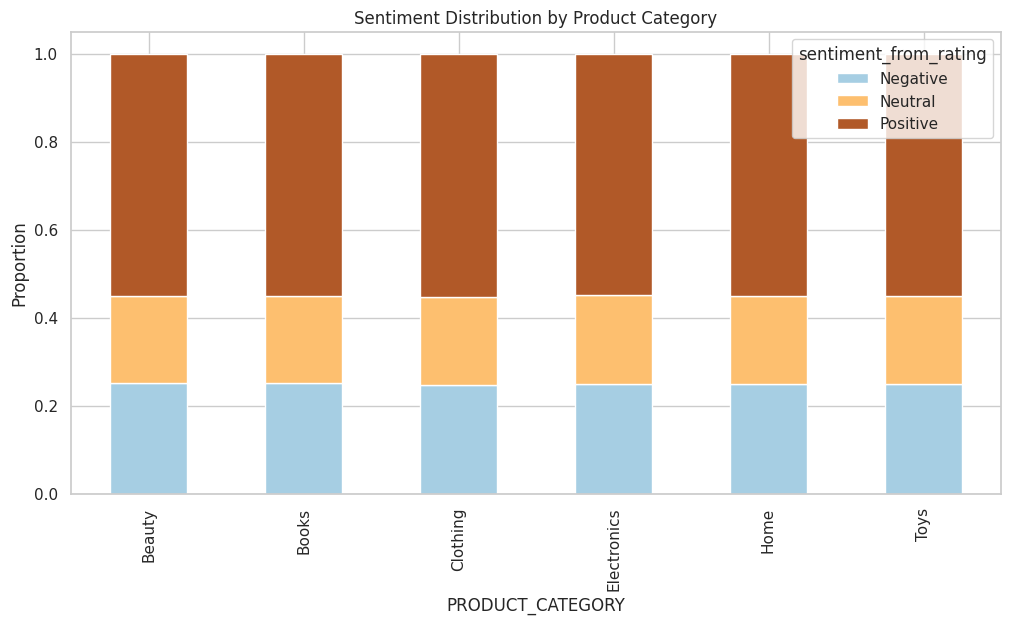

Business KPIs uploaded to Snowflake successfully.


In [22]:
# Step 8: Calculate Business KPIs

# NPS (Net Promoter Score)
# Assume NPS_RESPONSE column exists with values 0-10
def categorize_nps(score):
    if score >= 9:
        return 'Promoter'
    elif score >= 7:
        return 'Passive'
    else:
        return 'Detractor'

df_clean['NPS_CATEGORY'] = df_clean['NPS_RESPONSE'].apply(categorize_nps)

nps_score = ((df_clean['NPS_CATEGORY'] == 'Promoter').sum() -
             (df_clean['NPS_CATEGORY'] == 'Detractor').sum()) / len(df_clean) * 100
print("Net Promoter Score (NPS):", round(nps_score,2))

# CSAT (Customer Satisfaction) - average positive rating percentage
csat = (df_clean['REVIEW_RATING'] >= 4).mean() * 100
print("Customer Satisfaction (CSAT %):", round(csat,2))

# Churn Risk Analysis
churn_summary = df_clean.groupby('churn_risk_cat')['CHURN_RISK'].count().reset_index()
churn_summary.columns = ['Churn Risk', 'Count']

# Plot churn risk distribution
sns.set(style="whitegrid")
plt.figure(figsize=(8,5))
sns.barplot(x='Churn Risk', y='Count', data=churn_summary, palette='coolwarm')
plt.title("Churn Risk Distribution")
plt.ylabel("Number of Customers")
plt.show()

# 7.4: Insights by Product Category
category_summary = df_clean.groupby('PRODUCT_CATEGORY')['sentiment_from_rating'].value_counts(normalize=True).unstack().fillna(0)
category_summary.plot(kind='bar', stacked=True, figsize=(12,6), colormap='Paired')
plt.title("Sentiment Distribution by Product Category")
plt.ylabel("Proportion")
plt.show()

# 7.5: Save KPI table to Snowflake
kpi_df = pd.DataFrame({
    'NPS': [nps_score],
    'CSAT': [csat]
})

write_pandas(ctx, kpi_df, table_name="BUSINESS_KPIS", schema="ANALYSIS_DATA", auto_create_table=True)
print("Business KPIs uploaded to Snowflake successfully.")


In [26]:
# ==============================
# Step 9: Advanced Insights
# ==============================

import pandas as pd

# Start with basic KPIs
advanced_insights = pd.DataFrame({
    'NPS': [nps_score],
    'CSAT': [csat]
})

# Add churn risk counts
churn_counts = df_clean.groupby('churn_risk_cat')['CHURN_RISK'].count().reset_index()
churn_counts.columns = ['Churn_Risk', 'Count']
churn_counts_wide = churn_counts.pivot_table(index=None, columns='Churn_Risk', values='Count').reset_index(drop=True)
advanced_insights = pd.concat([advanced_insights, churn_counts_wide], axis=1)

# Sentiment distribution by product category
category_summary_reset = category_summary.reset_index()
category_summary_reset.columns = [f"{c}_Category" if isinstance(c,str) and c in ['Negative', 'Neutral', 'Positive'] else c for c in category_summary_reset.columns]
advanced_insights = pd.concat([advanced_insights.reset_index(drop=True), category_summary_reset.reset_index(drop=True)], axis=1)

# Device Type insights
device_summary_reset = device_summary.reset_index()
device_summary_reset.columns = [f"{c}_Device" if isinstance(c,str) and c in ['Negative', 'Neutral', 'Positive'] else c for c in device_summary_reset.columns]
advanced_insights = pd.concat([advanced_insights.reset_index(drop=True), device_summary_reset.drop('DEVICE_TYPE', axis=1).reset_index(drop=True)], axis=1)

# Top 10 countries with negative reviews
top_countries_neg = geo_summary['Negative'].sort_values(ascending=False).head(10).reset_index()
top_countries_neg.columns = ['Country', 'Neg_Review_Proportion_Country']
advanced_insights = pd.concat([advanced_insights.reset_index(drop=True), top_countries_neg.reset_index(drop=True)], axis=1)

# Customer journey stage sentiment
stage_summary_reset = stage_summary.reset_index()
stage_summary_reset.columns = [f"{c}_Stage" if isinstance(c,str) and c in ['Negative', 'Neutral', 'Positive'] else c for c in stage_summary_reset.columns]
advanced_insights = pd.concat([advanced_insights.reset_index(drop=True), stage_summary_reset.drop('JOURNEY_STAGE', axis=1).reset_index(drop=True)], axis=1)

# Support ticket & resolution metrics
support_res_summary = df_clean.groupby('sentiment_from_rating')['SUPPORT_RESOLUTION_TIME'].mean().reset_index()
support_res_summary.columns = ['Sentiment', 'Avg_Resolution_Time']
support_res_summary = support_res_summary.set_index('Sentiment').T.reset_index(drop=True)
support_res_summary.columns = [f"{c}_Avg_Resolution_Time" for c in support_res_summary.columns]
advanced_insights = pd.concat([advanced_insights.reset_index(drop=True), support_res_summary.reset_index(drop=True)], axis=1)


support_ticket_summary = df_clean.groupby('sentiment_from_rating')['SUPPORT_TICKET_FLAG'].sum().reset_index()
support_ticket_summary.columns = ['Sentiment', 'Total_Support_Tickets']
support_ticket_summary = support_ticket_summary.set_index('Sentiment').T.reset_index(drop=True)
support_ticket_summary.columns = [f"{c}_Total_Support_Tickets" for c in support_ticket_summary.columns]
advanced_insights = pd.concat([advanced_insights.reset_index(drop=True), support_ticket_summary.reset_index(drop=True)], axis=1)


# Loyalty Status sentiment
loyalty_summary_reset = loyalty_summary.reset_index()
loyalty_summary_reset.columns = [f"{c}_Loyalty" if isinstance(c,str) and c in ['Negative', 'Neutral', 'Positive'] else c for c in loyalty_summary_reset.columns]
advanced_insights = pd.concat([advanced_insights.reset_index(drop=True), loyalty_summary_reset.drop('LOYALTY_STATUS', axis=1).reset_index(drop=True)], axis=1)


# Numeric correlations
numeric_cols = ['PRODUCT_PRICE', 'DELIVERY_TIME_DAYS', 'SUPPORT_RESOLUTION_TIME', 'review_len', 'word_count']
numeric_corr = df_clean[numeric_cols].corr().reset_index()
numeric_corr.columns = [f"Corr_{c}" if c != 'index' else 'Feature' for c in numeric_corr.columns]
advanced_insights = pd.concat([advanced_insights.reset_index(drop=True), numeric_corr.reset_index(drop=True)], axis=1)

# Reset index
advanced_insights = advanced_insights.reset_index(drop=True)


# Save consolidated table to Snowflake
from snowflake.connector.pandas_tools import write_pandas

write_pandas(ctx, advanced_insights, table_name="ADVANCED_INSIGHTS", schema="ANALYSIS_DATA", auto_create_table=True)
print("All advanced insights saved to Snowflake table 'ADVANCED_INSIGHTS'.")

/tmp/ipython-input-2286035614.py:14: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  churn_counts = df_clean.groupby('churn_risk_cat')['CHURN_RISK'].count().reset_index()
/tmp/ipython-input-2286035614.py:16: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  churn_counts_wide = churn_counts.pivot_table(index=None, columns='Churn_Risk', values='Count').reset_index(drop=True)


All advanced insights saved to Snowflake table 'ADVANCED_INSIGHTS'.
